<a href="https://colab.research.google.com/github/Raaghashree/Intel-Products-Sentiment-Analysis/blob/main/ML_Sentiment_Analyser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUSTOM MODEL:

In [ ]:
!pip install torch
!pip install accelerate -U
!pip install transformers[torch] -U
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs

In [ ]:
import torch
torch.cuda.is_available()

In [ ]:
from datasets import load_dataset
imdb = load_dataset("imdb")
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)


In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [ ]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}


In [ ]:
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
from transformers import TrainingArguments, Trainer

repo_name = "finetuning-sentiment-model-3000-samples"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()


Step,Training Loss


TrainOutput(global_step=376, training_loss=0.30110574275889296, metrics={'train_runtime': 302.1825, 'train_samples_per_second': 19.856, 'train_steps_per_second': 1.244, 'total_flos': 782725021021056.0, 'train_loss': 0.30110574275889296, 'epoch': 2.0})

In [ ]:
trainer.evaluate()


<ipython-input-15-b1430cee0b64>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


{'eval_loss': 0.3272470235824585,
 'eval_accuracy': 0.8633333333333333,
 'eval_f1': 0.8637873754152824,
 'eval_runtime': 42.4653,
 'eval_samples_per_second': 7.065,
 'eval_steps_per_second': 0.447,
 'epoch': 2.0}

In [ ]:
trainer.push_to_hub()


**IMPLEMENTING MODEL**:

Installing necessary packages

In [30]:
pip install langdetect googletrans==4.0.0-rc1

MODEL:

In [31]:
from transformers import pipeline
sentiment_model = pipeline(model="Raagha/finetuning-sentiment-model-3000-samples")

Testing model on different languages

In [36]:
sentiment_model(["Me encanta esta canción, es realmente buena!", "esta película apesta"])

#LABEL_0 represents negative sentiment
#LABEL_1 represents positive sentiment

[{'label': 'LABEL_1', 'score': 0.72124183177948},
 {'label': 'LABEL_0', 'score': 0.5078819394111633}]

**Importing the required packages**

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from langdetect import detect
from googletrans import Translator

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Upload the files to be analysed**

In [59]:
from google.colab import files
uploaded = files.upload()

Saving Intel 13th gen data.csv to Intel 13th gen data.csv
Saving Intel 14th gen data.csv to Intel 14th gen data.csv


**Choose file to perform analysis on**

In [60]:
#Replace with different file name if required
df = pd.read_csv("Intel 13th gen data.csv")

**Preprocessing the data**

In [61]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stop_words.update(['cpu','good','would','one','stop','processor','intel','chip','gen','run','pc','used','return','arrived','box','new','amazon','issue','day',"don't",'open','great','open','core','use','get','buy','work','even','without','well','product','got','im','fine','like','didnt','tried','despite','month','case','high'])


In [62]:
print("Size of data:")
print("Before preprocessing:",df.shape)

def preprocessing(df):

    df.drop_duplicates(subset='reviewId', keep='first', inplace=True)
    df['reviewDescription'].fillna('', inplace=True)
    df['reviewDescription'] = df['reviewDescription'].astype(str).str.lower()

    def clean_text(text):
        text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
        words = nltk.word_tokenize(text)
        words = [word for word in words if word.isalpha()]  # Remove non-alphabetic tokens
        words = [word for word in words if word not in stop_words]  # Remove stop words
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(lemmatized_words)

    df['reviewDescription'] = df['reviewDescription'].apply(clean_text)
    return df

df = preprocessing(df)
print("After preprocessing:",df.shape)

Size of data:
Before preprocessing: (993, 7)
After preprocessing: (993, 7)


Analysing sentiment of reviews

In [75]:
tqdm.pandas()

def analyze_sentiment(review):
    try:
        result = sentiment_model(review[:512])[0]
        return result['label'], result['score']
    except Exception as e:
        print(f"Error processing review: {review[:50]}... | Error: {e}")
        return None, None

df[['sentiment_label', 'score']] = df['reviewDescription'].progress_apply(lambda x: pd.Series(analyze_sentiment(x)))

df = df.dropna(subset=['sentiment_label', 'score'])

df['sentiment'] = df['sentiment_label'].apply(lambda x: 'positive' if x == 'LABEL_1' else 'negative')


  0%|          | 0/993 [00:00<?, ?it/s]

Optional:

In [ ]:
# reviews with ratingScore 5
# Results in many false positives and affects recall
# Can be done if resulting dataframe has false negatives
#df['sentiment'] = df.apply(lambda row: 'positive' if row['ratingScore'] == 5 else row['sentiment'], axis=1)

Sentiments Tally:

In [76]:
def store_comments(df):
    positive_comments = df[(df['sentiment'] == 'positive')]['reviewDescription'].tolist()
    negative_comments = df[(df['sentiment'] == 'negative')]['reviewDescription'].tolist()
    return positive_comments, negative_comments

positive_comments, negative_comments = store_comments(df)

# Print the count of positive and negative comments
print(f"Number of positive comments: {len(positive_comments)}")
print(f"Number of negative comments: {len(negative_comments)}")


Number of positive comments: 687
Number of negative comments: 306


Negative reviews:

In [77]:
negative_reviews = df[(df['sentiment'] == 'negative')]
negative_reviews


,Id,reviewId,country,ratingScore,productAsin,reviewTitle,reviewDescription,sentiment_label,score,sentiment
0,1,R140DFFKFTKG4K,India,5,B0BCF57FL5,Nice,,LABEL_0,0.506557,negative
4,5,REI2D2XR93GT,United States,5,B0BCF57FL5,No need for undervolt,temp idle load low radiator,LABEL_0,0.587331,negative
10,11,R27WUIB7Y7QLCL,Germany,4,B0BN5XPHWW,alles bestens,e macht e sollpreis leistung ist auch okkönnte...,LABEL_0,0.507458,negative
19,20,R18BLLVRJDNEGD,Germany,5,B0BN5XPHWW,Super!,habe diesis produkt schnell bekommen und funkt...,LABEL_0,0.504523,negative
22,23,R1VO0FVIJRP7U,United States,3,B0BCF57FL5,Fast processor,run hot need massive cooling system system ove...,LABEL_0,0.797635,negative
...,...,...,...,...,...,...,...,...,...,...
978,979,R1VE8MV17FOZBE,France,4,B0BG6843GX,Un CPU Intel quoi ! Mais livraison lamentable,je suis extrêmement déçu par la livraison dun ...,LABEL_0,0.525375,negative
983,984,R1PJZRZT1QKFJ3,Germany,5,B0BN5YLBRG,Very satisfied!,time seal intact damaged processor work recomm...,LABEL_0,0.656431,negative
984,985,RTME80T8JD1WA,Germany,5,B0BN5YLBRG,Top Prozessor,der prozessor hat mich beeindruckt sehr schnel...,LABEL_0,0.516911,negative
989,990,R3N6S3WM1BMD1R,Germany,5,B0BN5YLBRG,Top Prozessor für Gaming,bin beeindruckt von der qualität und macht er ...,LABEL_0,0.525391,negative


Updated dataframe

In [78]:
df.head()

,Id,reviewId,country,ratingScore,productAsin,reviewTitle,reviewDescription,sentiment_label,score,sentiment
0,1,R140DFFKFTKG4K,India,5,B0BCF57FL5,Nice,,LABEL_0,0.506557,negative
1,2,RAM3AEE79280Q,India,5,B0BCF57FL5,Go for it..,absolutely incredible doubt keep mind go atlea...,LABEL_1,0.680114,positive
2,3,R3U6BJHPT28XMP,India,5,B0BCF57FL5,Best cpu at this price bracket,powerful price bracket doubt amazing performan...,LABEL_1,0.810242,positive
3,4,RU7YX4667K3DK,India,5,B0BCF57FL5,Just bought it! and working great except the t...,best far gaming editing run whatever throw exc...,LABEL_1,0.733112,positive
4,5,REI2D2XR93GT,United States,5,B0BCF57FL5,No need for undervolt,temp idle load low radiator,LABEL_0,0.587331,negative


Overall sentiment of reviews

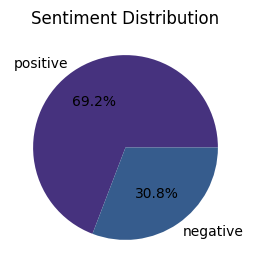

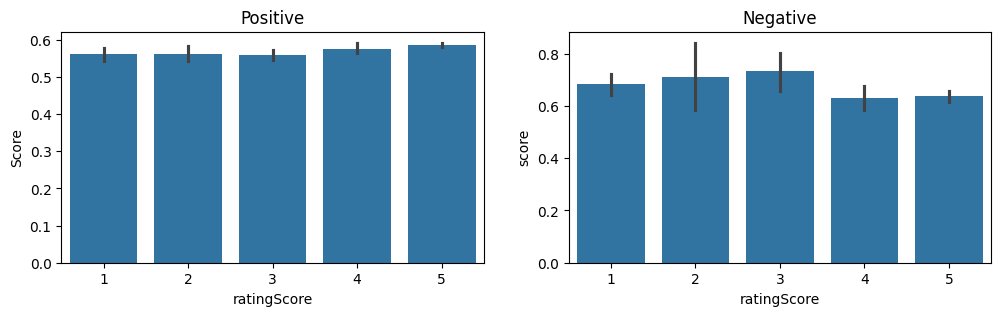

In [79]:
positive_count = len(positive_comments)
negative_count = len(negative_comments)

sentiment_distribution = pd.Series([positive_count, negative_count], index=['positive', 'negative'])
plt.figure(figsize=(4, 3))
plt.pie(sentiment_distribution.values, labels=sentiment_distribution.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'))
plt.title('Sentiment Distribution')
plt.show()

print("\n\n")
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

positive_df = df[df['sentiment'] == 'positive']
sns.barplot(data=positive_df, x='ratingScore', y='score', ax=axs[0])
axs[0].set_title('Positive')
axs[0].set_ylabel('Score')

negative_df = df[df['sentiment'] == 'negative']
sns.barplot(data=negative_df, x='ratingScore', y='score', ax=axs[1])
axs[1].set_title('Negative')
plt.show()


Extracting features using TF-IDF

Translating comments:   0%|          | 0/687 [00:00<?, ?it/s]

Translating comments:   0%|          | 0/306 [00:00<?, ?it/s]

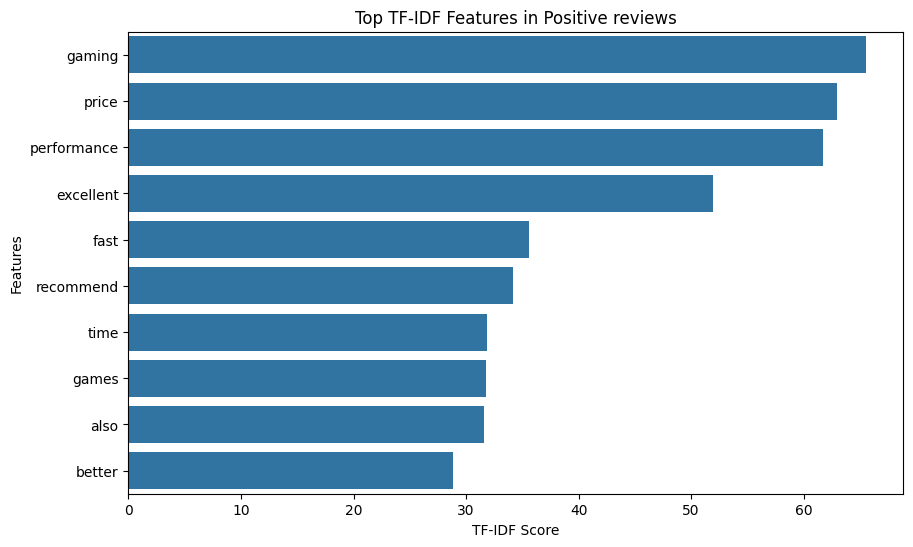

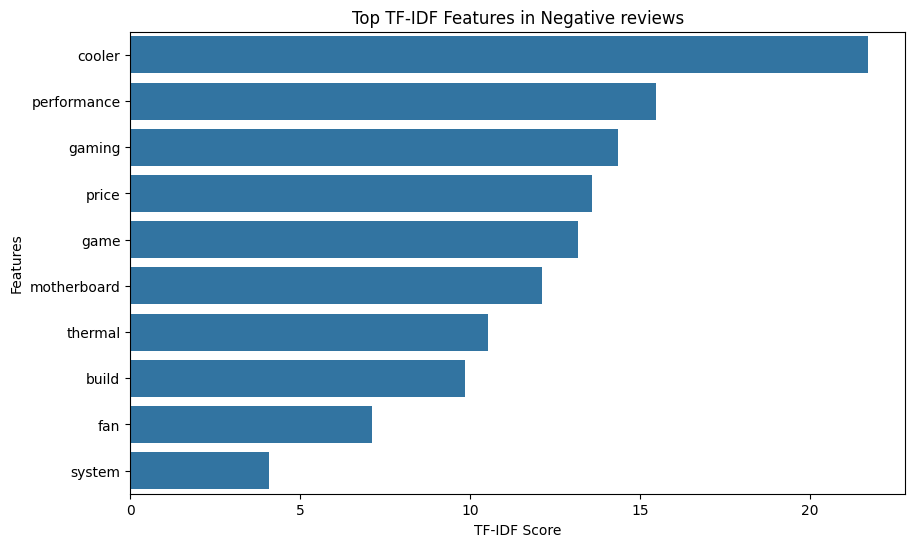

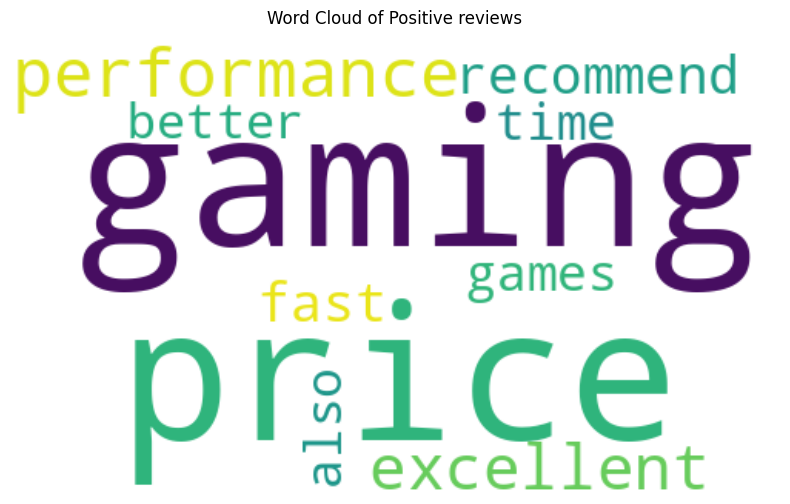

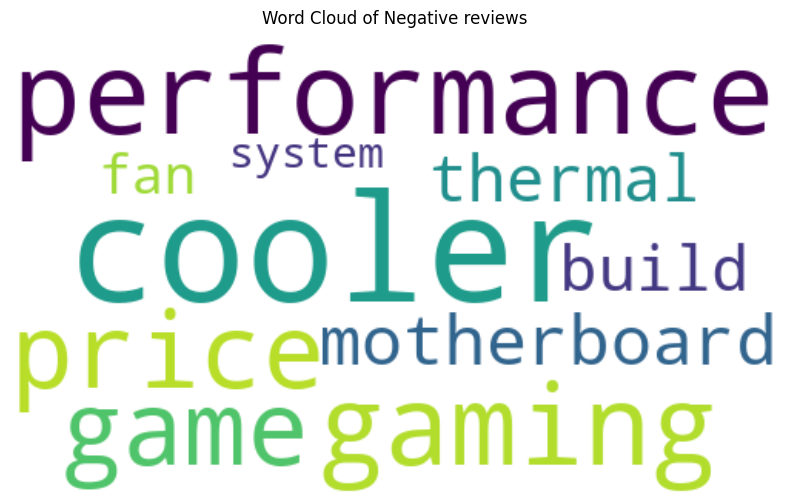

In [80]:
tqdm.pandas()
translator = Translator()

def detect_and_translate(review):
    try:
        lang = detect(review)
        if lang != 'en':
            translation = translator.translate(review, src=lang, dest='en')
            return translation.text
        else:
            return review
    except Exception:
        return None

def extract_features(comments, n_features=10):
    stop_words_list = list(stop_words)
    vectorizer = TfidfVectorizer(max_features=n_features, stop_words=stop_words_list)

    translated_comments = []
    for comment in tqdm(comments, desc="Translating comments"):
        translated_comment = detect_and_translate(comment)
        if translated_comment:
            translated_comments.append(translated_comment)

    tfidf_matrix = vectorizer.fit_transform(translated_comments)
    feature_names = vectorizer.get_feature_names_out()
    sums = tfidf_matrix.sum(axis=0)
    data = [(feature_names[col], sums[0, col]) for col in range(sums.shape[1])]
    ranking = pd.DataFrame(data, columns=['feature', 'tfidf']).sort_values(by='tfidf', ascending=False)

    return ranking

def plot_features_and_wordclouds(positive_features, negative_features):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='tfidf', y='feature', data=positive_features)
    plt.title('Top TF-IDF Features in Positive reviews')
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Features')
    plt.show()

    print("\n" * 3)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='tfidf', y='feature', data=negative_features)
    plt.title('Top TF-IDF Features in Negative reviews')
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Features')
    plt.show()

    print("\n" * 3)

    plt.figure(figsize=(10, 6))
    wordcloud_pos = WordCloud(width=500, height=300, background_color='white').generate_from_frequencies(dict(positive_features.values))
    plt.imshow(wordcloud_pos, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Positive reviews')
    plt.show()

    print("\n" * 3)

    plt.figure(figsize=(10, 6))
    wordcloud_neg = WordCloud(width=500, height=300, background_color='white').generate_from_frequencies(dict(negative_features.values))
    plt.imshow(wordcloud_neg, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Negative reviews')
    plt.show()

positive_features = extract_features(positive_comments)
negative_features = extract_features(negative_comments)

plot_features_and_wordclouds(positive_features, negative_features)


Training the model

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

In [81]:
X = df['reviewDescription']
y = df['sentiment']

num_runs = 10
accuracies = np.zeros(num_runs)
precisions = np.zeros(num_runs)
recalls = np.zeros(num_runs)
f1_scores = np.zeros(num_runs)

for i in range(num_runs):
    # Splitting data into sections
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    vect = TfidfVectorizer()
    X_train_tfidf = vect.fit_transform(X_train)
    X_test_tfidf = vect.transform(X_test)

    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)

    y_pred = model.predict(X_test_tfidf)

    #Storing metrics
    accuracies[i] = accuracy_score(y_test, y_pred)
    precisions[i] = precision_score(y_test, y_pred, pos_label='positive')
    recalls[i] = recall_score(y_test, y_pred, pos_label='positive')
    f1_scores[i] = f1_score(y_test, y_pred, pos_label='positive')


Evaluating model performance

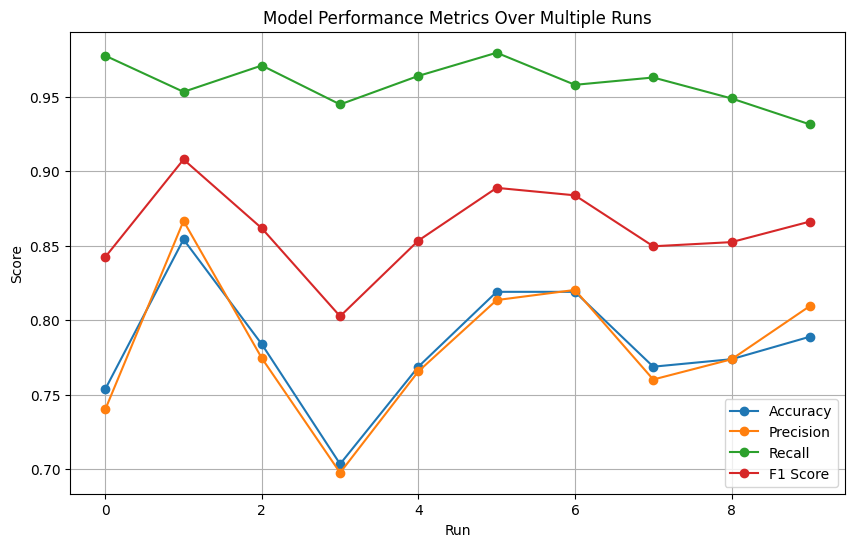


Average Accuracy: 0.7834170854271358
Average Precision: 0.7822220694257337
Average Recall: 0.9591879149671396
Average F1 Score: 0.8609429456098054


In [82]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_runs), accuracies, label='Accuracy', marker='o')
plt.plot(range(num_runs), precisions, label='Precision', marker='o')
plt.plot(range(num_runs), recalls, label='Recall', marker='o')
plt.plot(range(num_runs), f1_scores, label='F1 Score', marker='o')

plt.xlabel('Run')
plt.ylabel('Score')
plt.title('Model Performance Metrics Over Multiple Runs')
plt.legend()
plt.grid(True)
plt.show()

# Print average metrics
print(f"\nAverage Accuracy: {np.mean(accuracies)}")
print(f"Average Precision: {np.mean(precisions)}")

#Recall may be affected due to false positives
print(f"Average Recall: {np.mean(recalls)}")
print(f"Average F1 Score: {np.mean(f1_scores)}")

Confusion Matrix:


Confusion Matrix:



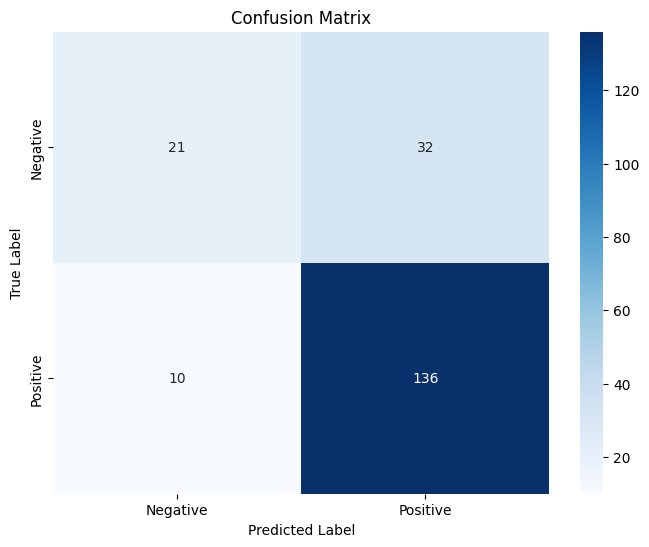


Results derived from Confusion Matrix

Accuracy: 0.7889447236180904
Precision: 0.8095238095238095
Recall: 0.9315068493150684
F1 Score: 0.8662420382165604



In [83]:
#raagha
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=['negative', 'positive'])

print("\nConfusion Matrix:\n")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

tn, fp, fn, tp = cm.ravel()

false_positives = fp

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("\nResults derived from Confusion Matrix")
print(f"\nAccuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}\n")
